# Imports and constants

In [520]:
# %pip install seaborn
# %pip install matplotlib
# %pip install networkx
# %pip install scikit-learn
# %pip install nltk

In [521]:
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import re
from sklearn.decomposition import TruncatedSVD

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

url_pattern = re.compile(r'https?://\S+|www\.\S+')
technical_terms = ['copyright', 'license', 'licensed', 'param', 'print', 'debug', 'exception', 'error', 'warning', 'recognition', 'detection', 'main', 'function', 'static', 'method', 'get', 'set', 'todo', 'fixme', 'bug', 'issue', 'pull', 'request', 'merge', 'conflict', 'commit', 'push', 'branch', 'master', 'origin', 'remote', 'local', 'repository', 'clone', 'fork', 'git', 'github', 'bitbucket', 'gitlab', 'vcs', 'version', 'control', 'system', 'software', 'development', 'project', 'team', 'member', 'collaborator', 'contributor', 'author', 'reviewer', 'manager', 'leader', 'owner', 'admin', 'administrator', 'class', 'interface', 'package' ]

In [522]:
import requests

def fetch_spdx_license_list():
    response = requests.get('https://raw.githubusercontent.com/spdx/license-list-data/master/json/licenses.json')
    if response.status_code == 200:
        licenses_data = response.json()
        return [license_data['licenseId'] for license_data in licenses_data['licenses']]
    else:
        return []

# Get the list of SPDX license identifiers
spdx_license_identifiers = fetch_spdx_license_list()
spdx_license_identifiers = spdx_license_identifiers + [license_token.split("-")[0] for license_token in spdx_license_identifiers]
# print(spdx_license_identifiers)


# Tokenize the text 

In [523]:
def isCamelCase(s):
    pattern = r'^[a-zA-Z]+([A-Z][a-z]+)+$'
    return bool(re.match(pattern, s))

def remove_javadoc_tags(text):
    lines = text.split('\n')
    output_lines = []
    
    for line in lines:
        if line.strip().startswith('@'):
            # Remove the tag part and keep the content after the tag
            tag_index = line.find(' ')
            if tag_index != -1:
                output_lines.append(line[tag_index + 1:])
        else:
            output_lines.append(line)
            
    return '\n'.join(output_lines)

# TODO: remove auto-generated comments
def process_text(text):
    text_without_url = url_pattern.sub(r'', text)
    removed_javadoc = remove_javadoc_tags(text_without_url)
    removed_license = [token for token in removed_javadoc.split() if token not in spdx_license_identifiers and token not in technical_terms]
    # print(removed_license)
    # print(text_without_url)
    tokens = word_tokenize(' '.join(removed_license))
    # remove punctuation
    cleaned_tokens = [token for token in tokens if token.isalpha()]

    removed_camel_case_tokens = [token for token in cleaned_tokens if not isCamelCase(token)]

    lemmatizer = WordNetLemmatizer()
    lemmatizer_tokens = [lemmatizer.lemmatize(token.lower()) for token in removed_camel_case_tokens]

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in lemmatizer_tokens if (token not in stop_words and token not in technical_terms)]

    return ' '.join(filtered_tokens)

# Extract url from the text

In [524]:
def extract_url(text):
    urls = url_pattern.findall(text)
    
    # cleaned_url = [url.rstrip('\'".,;])[') for url in urls]  
    # return cleaned_url
    # return urls

    filtered_urls = [re.split(r'\s|\[', url)[0] for url in urls]
    cleaned_url = [url.rstrip('\'".,;])') for url in filtered_urls]  
    return list(set(cleaned_url))

# Process the text and save it in a new location

In [525]:
input_dir = 'documentation'
output_dir = 'processedDocumentation'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

files_dictionary = {}
map_created = False


for root, dirs, files in os.walk(input_dir):
    if not map_created:
        map_created = True
        for dir in dirs:
            files_dictionary[dir] = []
    urls = []
   
    for file in files:
        if file.endswith('.txt'):
            input_file_path = os.path.join(root, file)
            output_file_path = input_file_path.replace(input_dir, output_dir)

            output_folder = os.path.dirname(output_file_path)
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            
            with open(input_file_path, 'r', encoding='utf-8') as input_file:
                text = input_file.read()
                processed_text = process_text(text)

                with open(output_file_path, 'w', encoding='utf-8') as output_file:
                    output_file.write(processed_text)
            urls.append(extract_url(text))
            files_dictionary[root.split("\\")[1]].append(file)
    if urls:
        output_file_url = os.path.join(root.replace(input_dir, output_dir), 'urls.txt')
        with open(output_file_url, 'w', encoding='utf-8') as output_file:
            for urls_child in urls:
                for url in urls_child:
                    output_file.write(str(url) + '\n')
                    
        files_dictionary[root.split("\\")[1]].append("url.txt")
# print(files_dictionary)


# Read the processed text

In [526]:
def read_processed_file(location):
    content = []
    with open(location, 'r', encoding='utf-8') as file:
        content.append(file.read())
    return ' '.join(content)

def read_processed_folder(directory, files):
    content = []
    for file in files:
        if file != "url.txt":
            location = os.path.join("processedDocumentation", directory, file)
            content.append(read_processed_file(location))
    return ' '.join(content)

# Readme cosine similarity

In [527]:
readmes = [read_processed_file("processedDocumentation\\" + folder + "\\readme.txt") for folder in files_dictionary.keys()]
# print(readmes)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_readme = tfidf_vectorizer.fit_transform(readmes)

num_docs_readme = len(readmes)
# print(num_docs)

similarities_readme = [[0 for _ in range(num_docs_readme)] for _ in range(num_docs_readme)]

for i in range(num_docs_readme):
    for j in range(num_docs_readme):
        similarities_readme[i][j] = cosine_similarity(tfidf_matrix_readme[i], tfidf_matrix_readme[j])[0][0]


for i in range(num_docs_readme):
    for j in range(num_docs_readme):
        if i < j:
            print(list(files_dictionary.keys())[i], list(files_dictionary.keys())[j], similarities_readme[i][j]) 

DUNGEON-pixel-dungeon-gradle_00-Evan DUNGEON-shattered-pixel-dungeon_00-Evan 0.4014210223006249
DUNGEON-pixel-dungeon-gradle_00-Evan FACE-CompreFace_exadel-inc 0.048536453998342444
DUNGEON-pixel-dungeon-gradle_00-Evan FACE-FaceRecognitionApp_Lauszus 0.259668711207974
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-BuildCraft_BuildCraft 0.11045043502572968
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-EnderIO-1.5-1.12_SleepyTrousers 0.036117304502183964
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-ImmersivePetroleum_Flaxbeard 0.02318249826311993
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-Mekanism_mekanism 0.05946794002796453
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-elasticsearch_spring-projects 0.073437568042519
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-jpa_spring-projects 0.07222204513105764
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-mongodb_spring-projects 0.07088939967292957
DUNGEON-shattered-pixel-dungeon_00-Evan FACE-CompreFace_exadel

# Wiki cosine similarity

In [528]:
wikis = [read_processed_file("processedDocumentation\\" + folder + "\\wiki.txt") if 'wiki.txt' in files_dictionary[folder] else '' for folder in files_dictionary.keys()]
# print(wikis)

# tfidf_vectorizer_wiki = TfidfVectorizer()
tfidf_matrix_wiki = tfidf_vectorizer.fit_transform(wikis)

num_docs_wiki = len(wikis)
# print(num_docs)

similarities_wiki = [[0 for _ in range(num_docs_wiki)] for _ in range(num_docs_wiki)]

for i in range(num_docs_wiki):
    for j in range(num_docs_wiki):
        similarities_wiki[i][j] = cosine_similarity(tfidf_matrix_wiki[i], tfidf_matrix_wiki[j])[0][0]


for i in range(num_docs_wiki):
    for j in range(num_docs_wiki):
        if i < j:
            print(list(files_dictionary.keys())[i], list(files_dictionary.keys())[j], similarities_wiki[i][j]) 

DUNGEON-pixel-dungeon-gradle_00-Evan DUNGEON-shattered-pixel-dungeon_00-Evan 0.0
DUNGEON-pixel-dungeon-gradle_00-Evan FACE-CompreFace_exadel-inc 0.0
DUNGEON-pixel-dungeon-gradle_00-Evan FACE-FaceRecognitionApp_Lauszus 0.0
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-BuildCraft_BuildCraft 0.0
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-EnderIO-1.5-1.12_SleepyTrousers 0.0
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-ImmersivePetroleum_Flaxbeard 0.0
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-Mekanism_mekanism 0.0
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-elasticsearch_spring-projects 0.0
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-jpa_spring-projects 0.0
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-mongodb_spring-projects 0.0
DUNGEON-shattered-pixel-dungeon_00-Evan FACE-CompreFace_exadel-inc 0.0
DUNGEON-shattered-pixel-dungeon_00-Evan FACE-FaceRecognitionApp_Lauszus 0.0
DUNGEON-shattered-pixel-dungeon_00-Evan MINECRAFT-BuildCraft_BuildCraft 

# Comments cosine similarity

In [529]:
comments = [read_processed_file("processedDocumentation\\" + folder + "\\comments.txt") if 'comments.txt' in files_dictionary[folder] else '' for folder in files_dictionary.keys()]
# print(wikis)

# tfidf_vectorizer_wiki = TfidfVectorizer()
tfidf_matrix_comm = tfidf_vectorizer.fit_transform(comments)

num_docs_comm = len(comments)
# print(num_docs)

similarities_comments = [[0 for _ in range(num_docs_comm)] for _ in range(num_docs_comm)]

for i in range(num_docs_comm):
    for j in range(num_docs_comm):
        similarities_comments[i][j] = cosine_similarity(tfidf_matrix_comm[i], tfidf_matrix_comm[j])[0][0]


for i in range(num_docs_comm):
    for j in range(num_docs_comm):
        if i < j:
            print(list(files_dictionary.keys())[i], list(files_dictionary.keys())[j], similarities_comments[i][j]) 

DUNGEON-pixel-dungeon-gradle_00-Evan DUNGEON-shattered-pixel-dungeon_00-Evan 0.9559718066641846
DUNGEON-pixel-dungeon-gradle_00-Evan FACE-CompreFace_exadel-inc 0.15245665613669368
DUNGEON-pixel-dungeon-gradle_00-Evan FACE-FaceRecognitionApp_Lauszus 0.07217229682082517
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-BuildCraft_BuildCraft 0.12772826048238095
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-EnderIO-1.5-1.12_SleepyTrousers 0.03336602905124596
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-ImmersivePetroleum_Flaxbeard 0.018188710892578695
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-Mekanism_mekanism 0.019233591680342842
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-elasticsearch_spring-projects 0.13001759296709062
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-jpa_spring-projects 0.125590329958567
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-mongodb_spring-projects 0.0733743794685531
DUNGEON-shattered-pixel-dungeon_00-Evan FACE-CompreFace_exade

# Combined cosine similarity

In [530]:
combined = [read_processed_folder(folder, files_dictionary[folder]) for folder in files_dictionary.keys()]

tfidf_matrix_comm = tfidf_vectorizer.fit_transform(combined)

# num_topics = 100
# lsa_model = TruncatedSVD(n_components=num_topics)
# lsa_matrix = lsa_model.fit_transform(tfidf_matrix_comm)

num_docs_combined = len(combined)
# print(num_docs)

similarities_combined = [[0 for _ in range(num_docs_combined)] for _ in range(num_docs_combined)]

for i in range(num_docs_combined):
    for j in range(num_docs_combined):
        similarities_combined[i][j] = cosine_similarity(tfidf_matrix_comm[i], tfidf_matrix_comm[j])[0][0]


for i in range(num_docs_combined):
    for j in range(num_docs_combined):
        if i < j:
            print(list(files_dictionary.keys())[i], list(files_dictionary.keys())[j], similarities_combined[i][j]) 

DUNGEON-pixel-dungeon-gradle_00-Evan DUNGEON-shattered-pixel-dungeon_00-Evan 0.9562168733290215
DUNGEON-pixel-dungeon-gradle_00-Evan FACE-CompreFace_exadel-inc 0.15579102539495696
DUNGEON-pixel-dungeon-gradle_00-Evan FACE-FaceRecognitionApp_Lauszus 0.08961786428930898
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-BuildCraft_BuildCraft 0.13562051030445926
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-EnderIO-1.5-1.12_SleepyTrousers 0.018121506348911947
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-ImmersivePetroleum_Flaxbeard 0.010157495381239988
DUNGEON-pixel-dungeon-gradle_00-Evan MINECRAFT-Mekanism_mekanism 0.02401863750943294
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-elasticsearch_spring-projects 0.1338972500537517
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-jpa_spring-projects 0.13167568574652055
DUNGEON-pixel-dungeon-gradle_00-Evan SPRING-spring-data-mongodb_spring-projects 0.07710902887234868
DUNGEON-shattered-pixel-dungeon_00-Evan FACE-CompreFace_exa

# Data visualization

## Heatmap

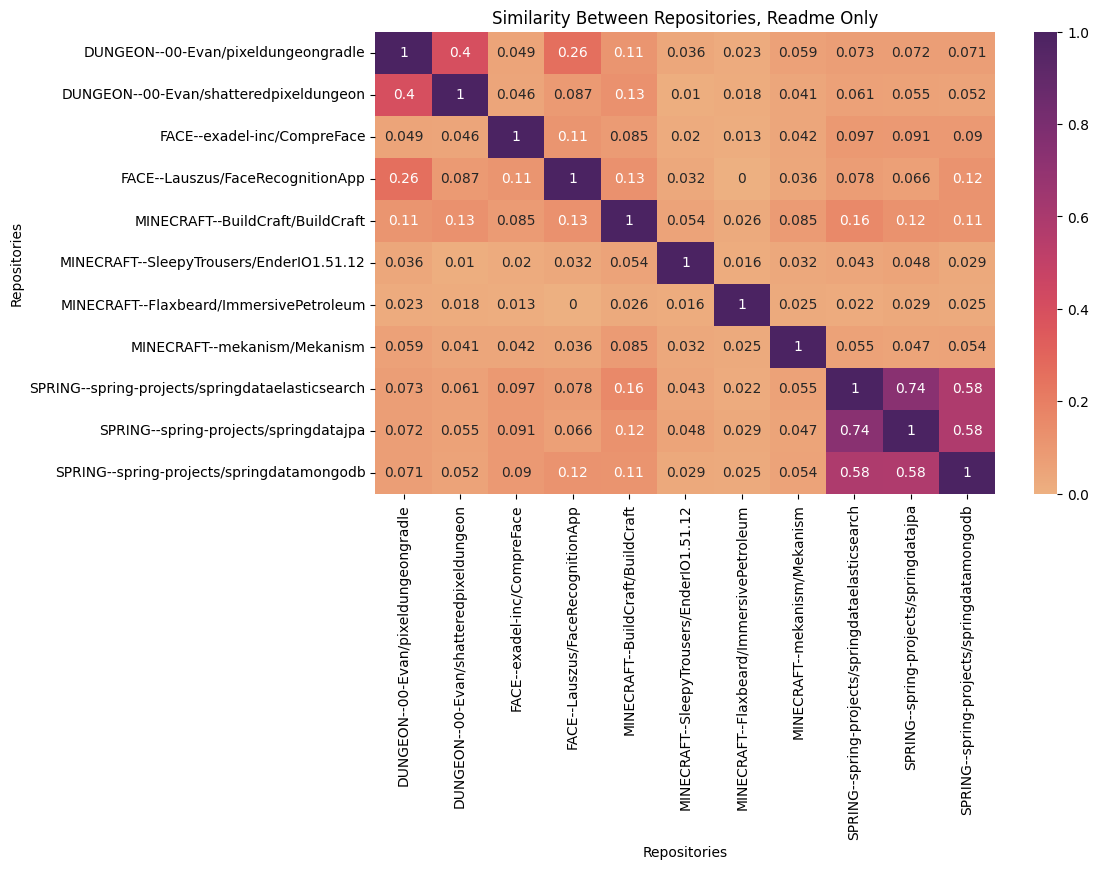

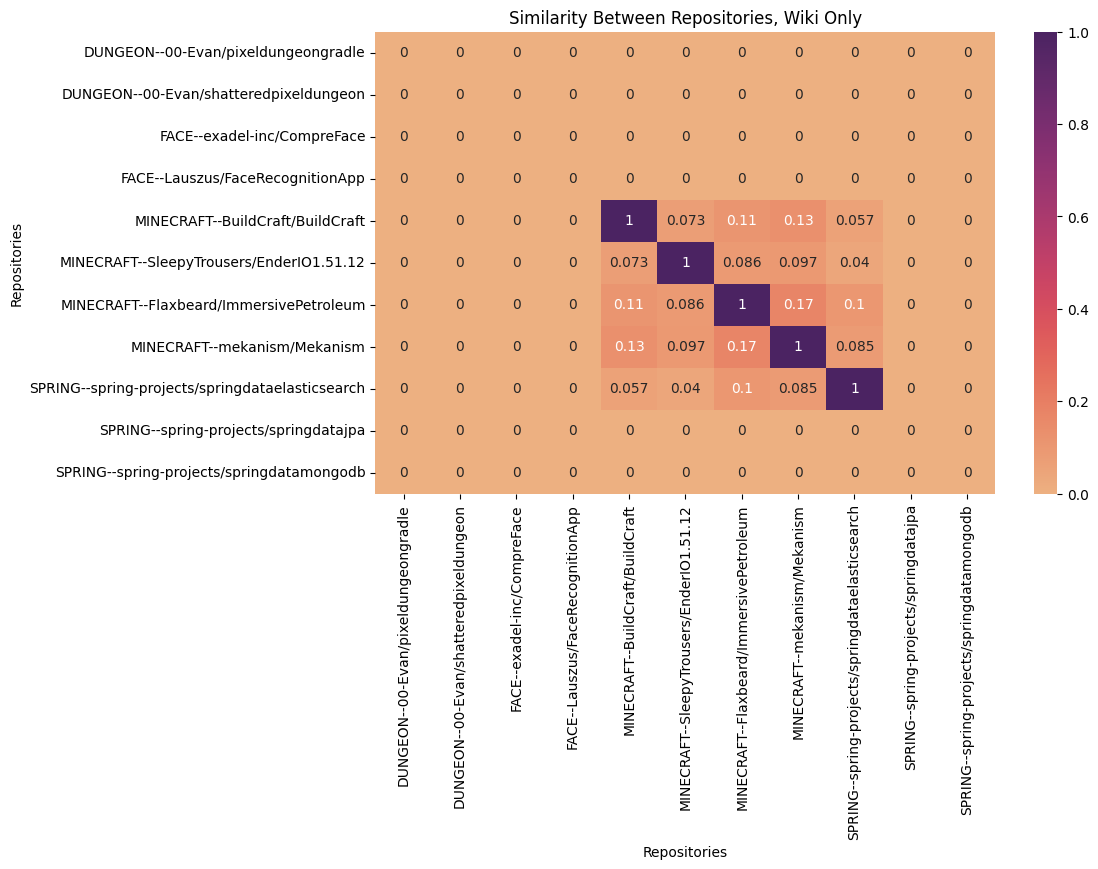

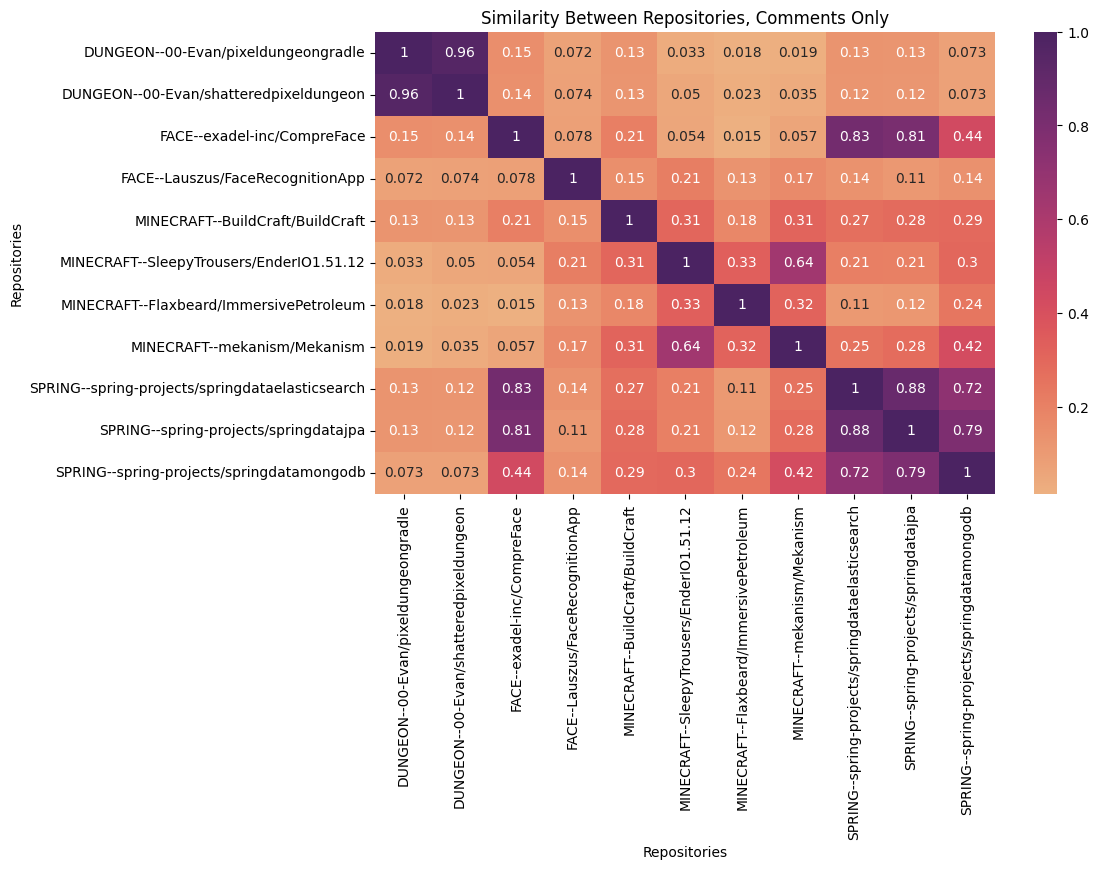

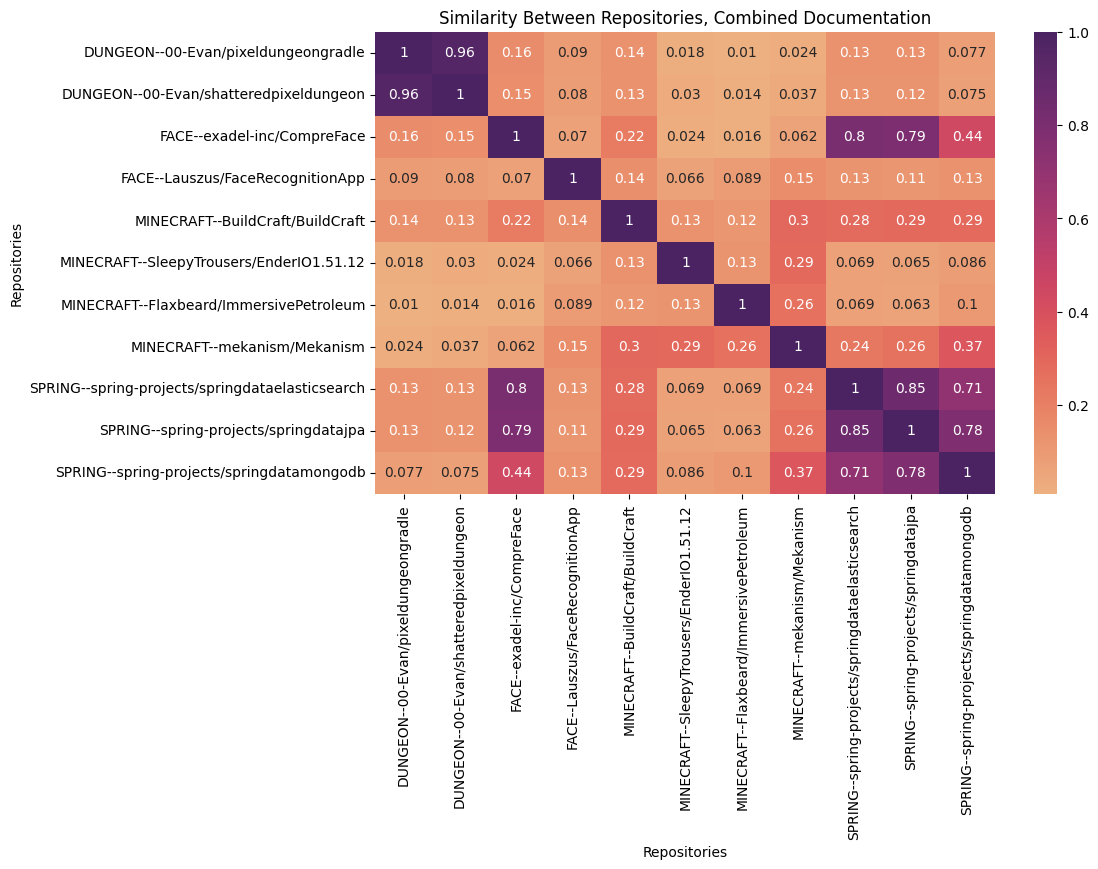

In [531]:
similarity_types = [similarities_readme, similarities_wiki, similarities_comments, similarities_combined]
title = ["Readme Only", "Wiki Only", "Comments Only", "Combined Documentation"]
    
labels = [repo.split("-")[0]  + "--"+ repo.split("_")[1] + "/" + ''.join(repo.split("_")[0].split("-")[1:]) for repo in files_dictionary.keys()] 
# labels = [repo.split("_")[1] + "/" + repo.split("_")[0] for repo in files_dictionary.keys()] 

for index, sim in enumerate(similarity_types):
    plt.figure(figsize=(10, 6))

    sns.heatmap(sim, annot=True, cmap="flare", xticklabels=labels, yticklabels=labels)
    plt.title('Similarity Between Repositories, ' + title[index])
    plt.xlabel('Repositories')
    plt.ylabel('Repositories')
    plt.show()


## Network graph

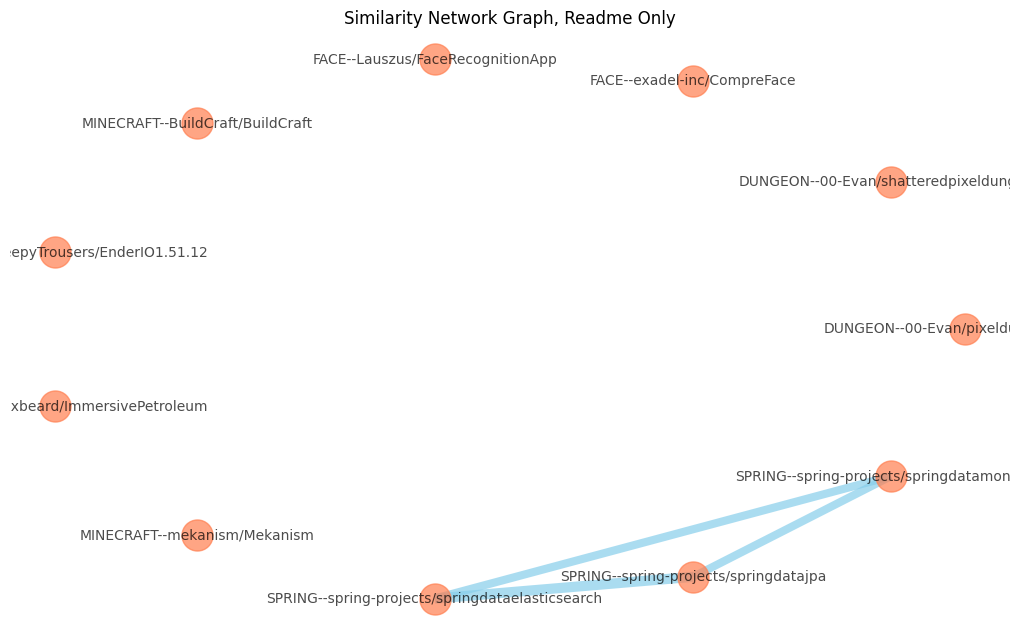

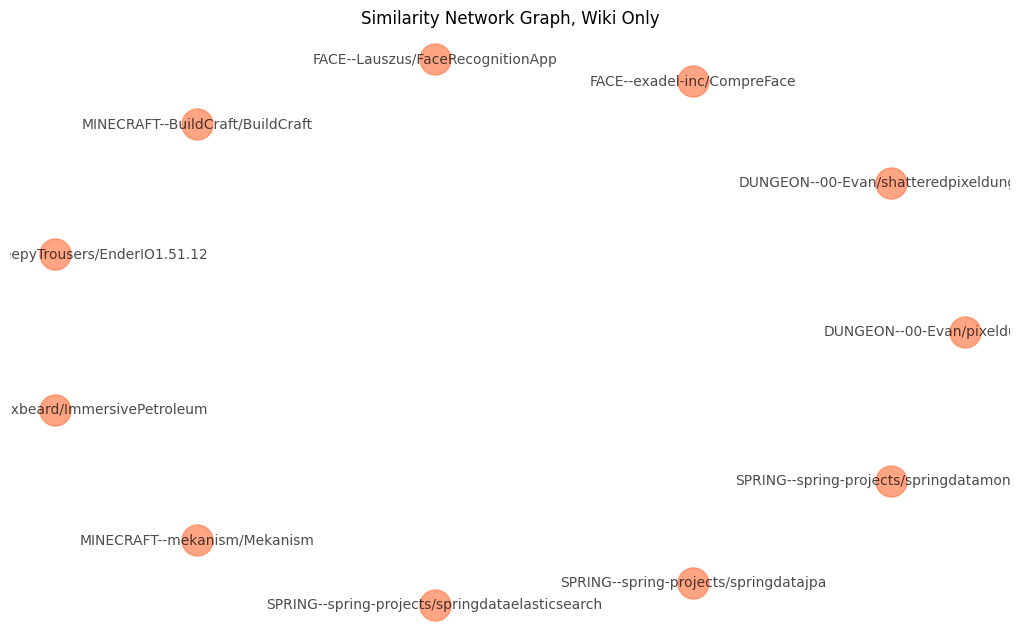

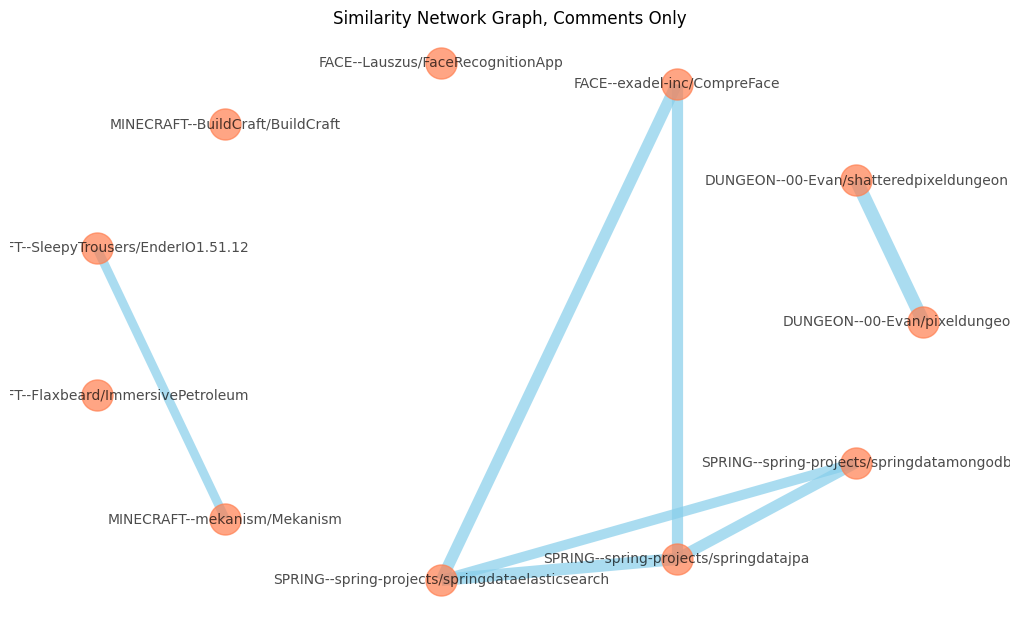

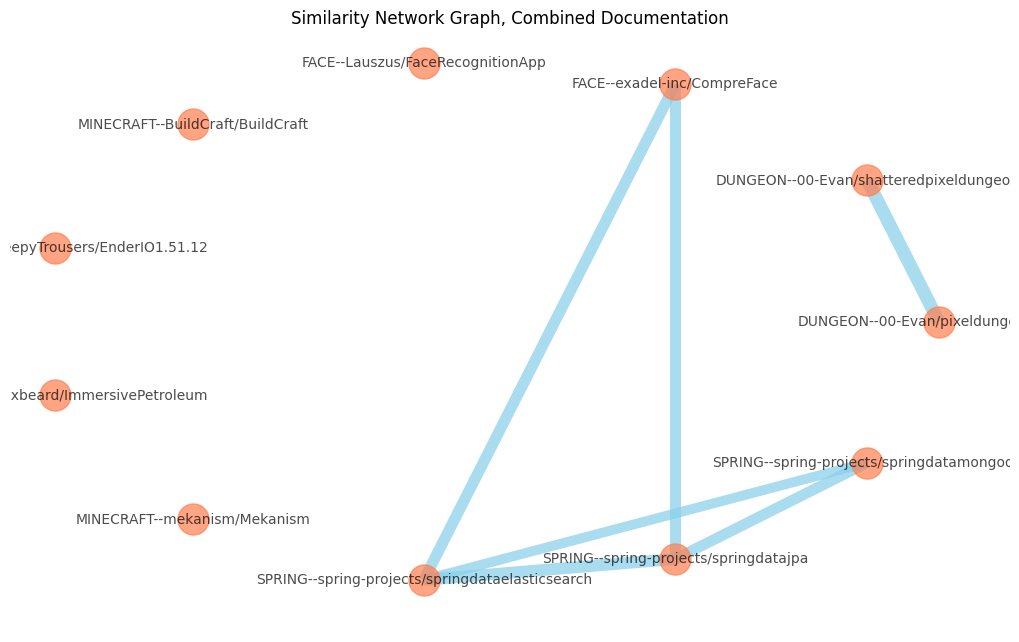

In [532]:
import networkx as nx

for index, sim in enumerate(similarity_types):


    G = nx.Graph()

    for label in labels:
        G.add_node(label)

    threshold = 0.5
    for i in range(num_docs_combined):
        for j in range(i+1, num_docs_combined):
            if sim[i][j] > threshold:
                G.add_edge(labels[i], labels[j], weight=sim[i][j])
    # pos = nx.spring_layout(G)  
    # pos = nx.shell_layout(G)
    # pox = nx.kamada_kawai_layout(G)
    pos = nx.circular_layout(G)

    edge_widths = [d['weight'] * 10 for (u, v, d) in G.edges(data=True)]
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, edge_color='skyblue', node_color = 'coral', width=edge_widths, alpha=0.7, style='solid')
    plt.title('Similarity Network Graph, ' + title[index] )
    plt.show()

# Documentation Distribution

posx and posy should be finite values


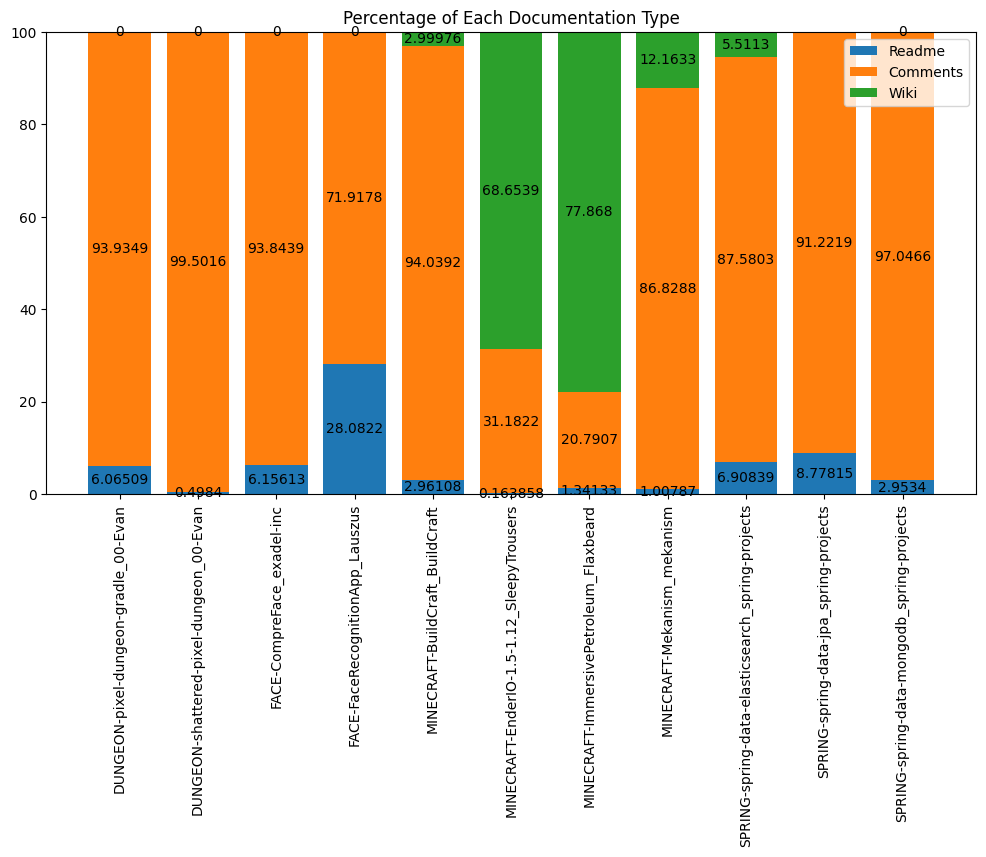

In [533]:
def count_tokens(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        tokens = content.split(" ")
        return len(tokens)

def calculate_percentage(count, total):
    return (count / total) * 100

folders = os.listdir("processedDocumentation")


readme_percentages = []
comments_percentages = []
wiki_percentages = []


for folder in folders:
    readme_count = 0
    comments_count = 0
    wiki_count = 0
    total_count = 0

    folder_path = os.path.join("processedDocumentation", folder)
    files = os.listdir(folder_path)
    for file in files:
        if file.endswith('.txt'):
            file_path = os.path.join(folder_path, file)
            if file == 'readme.txt':
                readme_count += count_tokens(file_path)
            elif file == 'comments.txt':
                comments_count += count_tokens(file_path)
            elif file == 'wiki.txt':
                wiki_count += count_tokens(file_path)

    total_count = readme_count + comments_count + wiki_count

    readme_percentage = calculate_percentage(readme_count, total_count)
    comments_percentage = calculate_percentage(comments_count, total_count)
    wiki_percentage = calculate_percentage(wiki_count, total_count)

    readme_percentages.append(readme_percentage)
    comments_percentages.append(comments_percentage)
    wiki_percentages.append(wiki_percentage)

labels = ['Readme', 'Comments', 'Wiki']
# print(wiki_percentages)
# print(readme_percentages)
# print(comments_percentages)

counts = {
    "Readme": readme_percentages,
    "Comments": comments_percentages,
    "Wiki": wiki_percentages
}


fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(folders))

for doc, count in counts.items():
    p = ax.bar(folders, count, bottom=bottom, label=doc)
    # print(doc, count)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Percentage of Each Documentation Type')
ax.legend()
plt.xticks(rotation=90)
plt.show()

# Dendrogram

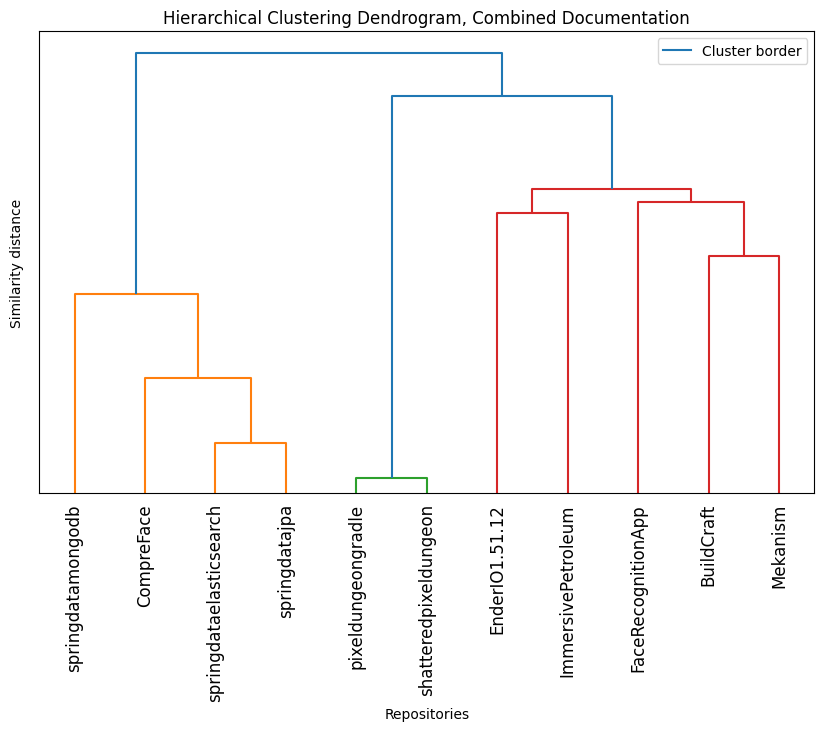

In [534]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import matplotlib.lines as mlines 

labels2 = [''.join(repo.split("_")[0].split("-")[1:]) for repo in files_dictionary.keys()] 

linkage_matrix = hierarchy.linkage(similarities_combined, method='complete') 

plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=labels2, leaf_rotation=90)
plt.xlabel('Repositories')
plt.ylabel('Similarity distance')
plt.title('Hierarchical Clustering Dendrogram, Combined Documentation')
plt.tick_params(axis='y', left=False)
plt.gca().set(yticklabels=[])

threshold_legend = mlines.Line2D([], [], color='#1f77b4', linestyle='-', label=f'Cluster border')
plt.legend(handles=[threshold_legend])
plt.show()